# Librairies

In [1]:
import geopandas as gpd
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pylab as plt
import zipfile

# Load data

In [2]:
# Cities to investigate
cities = [
    'London',
    'Manchester',
    'Birmingham',
    'Cardiff',
    'Glasgow City',
    'City of Edinburgh'
]

city = cities[-2]

In [3]:
# Read file and filter the city
with zipfile.ZipFile('raw/dft_traffic_counts_aadf.zip') as z :
    file = z.open('dft_traffic_counts_aadf.csv')
    
    df = pd.read_csv(file)
    if city != 'London':
        # We get the local authority
        df = df[df.local_authority_name == city]
    else :
        # London is a region
        df = df[df.region_name == 'London']

C:\Users\xbonnema\AppData\Local\Temp\ipykernel_14380\1719076358.py:5: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [4]:
print(np.sort(df.year.unique()))

[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]


In [5]:
df.columns

Index(['count_point_id', 'year', 'region_id', 'region_name', 'region_ons_code',
       'local_authority_id', 'local_authority_name', 'local_authority_code',
       'road_name', 'road_category', 'road_type', 'start_junction_road_name',
       'end_junction_road_name', 'easting', 'northing', 'latitude',
       'longitude', 'link_length_km', 'link_length_miles', 'estimation_method',
       'estimation_method_detailed', 'pedal_cycles',
       'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches',
       'LGVs', 'HGVs_2_rigid_axle', 'HGVs_3_rigid_axle',
       'HGVs_4_or_more_rigid_axle', 'HGVs_3_or_4_articulated_axle',
       'HGVs_5_articulated_axle', 'HGVs_6_articulated_axle', 'all_HGVs',
       'all_motor_vehicles'],
      dtype='object')

In [8]:
df.rename(columns = 
          {
       'two_wheeled_motor_vehicles' : '2W_AADT', 
       'all_HGVs' : 'TR_AADT',
       'all_motor_vehicles' : 'AADT', 
       },
          inplace=True
          )

In [9]:
df['estimation_method'].unique()

array(['Estimated', 'Counted'], dtype=object)

In [10]:
df['estimation_method_detailed'].unique()

array(['Estimated from nearby links', 'Automatic counter',
       "Estimated using previous year's AADF on this link",
       'Manual count', 'Dependent on a neighbouring counted link'],
      dtype=object)

In [11]:
df = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
    crs = 'epsg:4326'
)

In [12]:
df.geometry.unique().size

488

In [15]:
df['raw_direction'] = df['start_junction_road_name'] + '-->' + df['end_junction_road_name']

In [17]:
df.count_point_id.unique().size

300

In [19]:
df.year.value_counts().sort_index()[-10:]

year
2014    201
2015    201
2016    199
2017    200
2018    211
2019    233
2020    197
2021    199
2022    199
2023    199
Name: count, dtype: int64

# Map matching with OSM

In [13]:
df_unique = df.drop_duplicates(subset = ['count_point_id'])

(-4.482593536376953, -4.043028403048634, 55.77681413679656, 55.92468198376778)

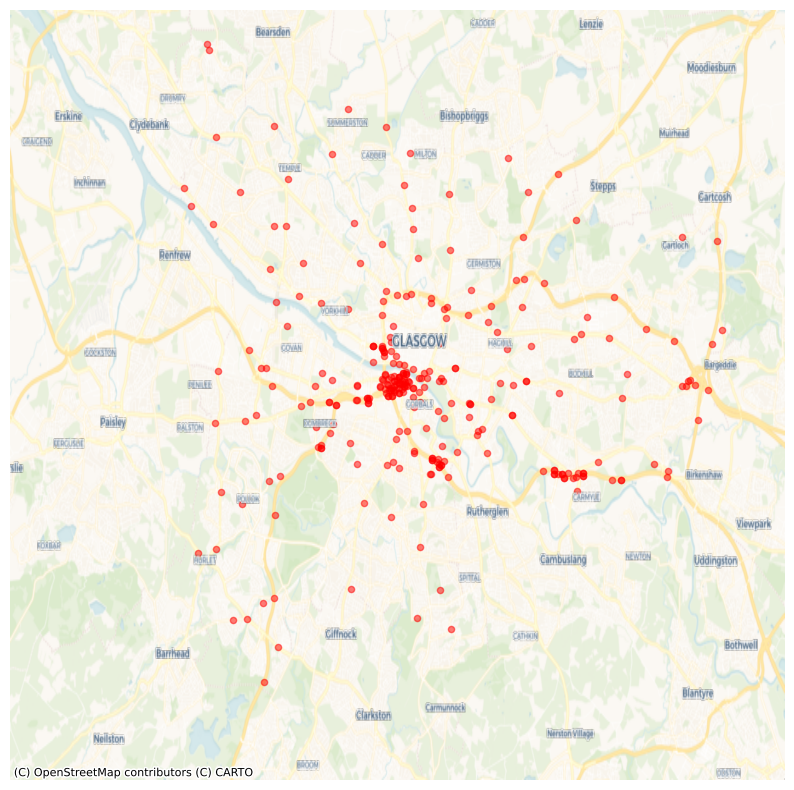

In [14]:
import contextily as cx

# Plot sensors
ax = df_unique.plot(color = 'r', markersize = 20, alpha = .5, figsize = (10,10))
# Add context in backround
cx.add_basemap(ax, crs = df_unique.crs, source=cx.providers.CartoDB.VoyagerNoLabels)

cx.add_basemap(ax, crs = df_unique.crs, source=cx.providers.CartoDB.VoyagerOnlyLabels)

# Remove lat lon
plt.axis('off')
plt.axis('auto')

In [15]:
import sys
from pathlib import Path

# Add the ../assets directory to sys.path
sys.path.append(str(Path("../assets").resolve()))

from map_matching_OSM import points_matching

In [16]:
df_unique = points_matching(df_unique)

City downloaded


 24%|██▍       | 73/300 [00:00<00:02, 98.60it/s] 

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 42%|████▏     | 126/300 [00:01<00:01, 120.46it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 57%|█████▋    | 172/300 [00:01<00:00, 141.17it/s]

Value Error - No roads found nearby current index


 92%|█████████▏| 277/300 [00:02<00:00, 166.27it/s]

Value Error - No roads found nearby current index


100%|██████████| 300/300 [00:02<00:00, 131.95it/s]

Value Error - No roads found nearby current index
We failed to match 8 sensors
...on a total of 300 sensors


In [17]:
# No street name to compare (only start and end street names, the 'road_name' attribute is just a code)

In [17]:
df_unique[['road_name', 'osm_name']].drop_duplicates().dropna()

,road_name,osm_name
132,A8,Gloucester Street
3909,A8,Centre Street
3914,A8,Kingston Street
3919,A8,Saltmarket
4231,A77,George V Bridge
...,...,...
544604,U,Corkerhill Place
544620,U,Woodville Street
544653,B763,Polmadie Road
546571,U,Garrioch Road


In [19]:
# Join with OSM information
df = df.set_index('count_point_id').join(
    df_unique.set_index('count_point_id')[[
        'osm_name', 'highway', 'lanes', 'distance', 'osmid'
    ]],
    how = 'inner'
)

In [28]:
# for year in range(2015, 2024):
#     df[df.year == year][[
#         'AADT', 'TR_AADT', '2W_AADT', 'geometry', 'closest_road', 'highway', 'distance', 'osmid'
#     ]].to_file(
#         f'{city_key[city]}/treated/{city_key[city]}_AADT_{year}.geojson',
#         index = False
#         )

# Loop on each city

In [2]:
import sys
from pathlib import Path

# Add the ../assets directory to sys.path
sys.path.append(str(Path("../assets").resolve()))

from map_matching_OSM import points_matching
from validate_dataset import validate_dataset

In [3]:
city_key = {
        'London' : 'London',
    'Manchester' : 'Manchester',
    'Birmingham' :'Birmingham',
    'Cardiff' :'Cardiff' ,
    'Glasgow City' : 'Glasgow',
    'City of Edinburgh' : 'Edinburgh'
}
# Cities to investigate
cities = [
    'London',
    'Manchester',
    'Birmingham',
    'Cardiff',
    'Glasgow City',
    'City of Edinburgh'
]

In [4]:
# Loop these steps on each city

for city in cities[:-1] :
    print(city)
    # Read file and filter the city
    with zipfile.ZipFile('raw/dft_traffic_counts_aadf.zip') as z :
        file = z.open('dft_traffic_counts_aadf.csv')
        
        df = pd.read_csv(file)
        if city != 'London':
            # We get the local authority
            df = df[df.local_authority_name == city]
        else :
            # London is a region
            df = df[df.region_name == 'London']
            
        if city == 'Glasgow City':
            # There is an error in position values of count_point_id 82039 and 82040 for 2021-2023 and 2021 respectively 
            # These positions are changed from previous years and do not correspond to a road
            # We should correct it
            print('Correct positions')
            df.loc[(df.count_point_id == 82039) & (df.year >= 2021), 'latitude'] = 55.849756
            df.loc[(df.count_point_id == 82039) & (df.year >= 2021), 'longitude'] = -4.286587
            df.loc[(df.count_point_id == 82040) & (df.year == 2021), 'latitude'] = 55.849759
            df.loc[(df.count_point_id == 82040) & (df.year == 2021), 'longitude'] = -4.279654
    
    # Rename columns
    df.rename(columns = 
            {
        'two_wheeled_motor_vehicles' : '2W_AADT', 
        'all_HGVs' : 'TR_AADT',
        'all_motor_vehicles' : 'AADT', 
        'road_name':'raw_name',
        'estimation_method_detailed' : 'raw_techno'
        },
            inplace=True
            )
    # geodataframe
    df = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
        crs = 'epsg:4326'
    )

    # Map matching with OSM
    df_unique = df.drop_duplicates(subset = ['count_point_id'])
    df_unique = points_matching(df_unique)

    # Join with OSM information
    df = df.set_index('count_point_id').join(
        df_unique.set_index('count_point_id')[[
            'osm_name', 'osm_type', 'osm_lanes', 'osm_oneway', 'osm_distance', 'osm_maxspeed', 'osmid'
        ]],
        how = 'inner'
    )
    # Add direction information
    df['raw_direction'] = df['start_junction_road_name'] + '-->' + df['end_junction_road_name']
    df['raw_oneway'] = True
    
    # Validate the dataset
    df = validate_dataset(df)
    
    # Final saving
    for year in range(2015, 2024):
        df[df.year == year][[
            'AADT', 'TR_AADT', '2W_AADT', 'geometry', 'raw_name', 'raw_oneway', 'raw_direction', 'raw_techno', 'osm_name', 'osm_type', 'osm_lanes', 'osm_oneway', 'osm_distance', 'osm_maxspeed', 'osmid'
        ]].to_file(
            f'{city_key[city]}/treated/{city_key[city]}_AADT_{year}.geojson',
            index = False
            )

London
City downloaded


  0%|          | 17/3616 [00:00<02:36, 23.05it/s]

Value Error - No roads found nearby current index


  2%|▏         | 89/3616 [00:03<02:15, 26.11it/s]

Value Error - No roads found nearby current index


  6%|▌         | 210/3616 [00:07<02:21, 24.08it/s]

Value Error - No roads found nearby current index


  7%|▋         | 252/3616 [00:09<02:18, 24.20it/s]

Value Error - No roads found nearby current index


 10%|█         | 369/3616 [00:13<02:04, 26.04it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 10%|█         | 375/3616 [00:14<02:31, 21.41it/s]

Value Error - No roads found nearby current index


 12%|█▏        | 442/3616 [00:16<02:20, 22.55it/s]

Value Error - No roads found nearby current index


 15%|█▍        | 542/3616 [00:20<01:41, 30.32it/s]

Value Error - No roads found nearby current index


 17%|█▋        | 604/3616 [00:22<01:41, 29.59it/s]

Value Error - No roads found nearby current index


 19%|█▉        | 690/3616 [00:25<01:58, 24.60it/s]

Value Error - No roads found nearby current index


 21%|██        | 749/3616 [00:27<02:23, 20.04it/s]

Value Error - No roads found nearby current index


 23%|██▎       | 830/3616 [00:30<01:29, 31.02it/s]

Value Error - No roads found nearby current index


 23%|██▎       | 838/3616 [00:31<01:39, 27.79it/s]

Value Error - No roads found nearby current index


 29%|██▊       | 1032/3616 [00:38<01:41, 25.35it/s]

Value Error - No roads found nearby current index


 29%|██▊       | 1039/3616 [00:38<01:54, 22.43it/s]

Value Error - No roads found nearby current index


 30%|██▉       | 1082/3616 [00:40<01:48, 23.27it/s]

Value Error - No roads found nearby current index


 34%|███▎      | 1216/3616 [00:45<01:53, 21.19it/s]

Value Error - No roads found nearby current index


 34%|███▍      | 1238/3616 [00:46<01:47, 22.22it/s]

Value Error - No roads found nearby current index


 34%|███▍      | 1247/3616 [00:47<01:57, 20.12it/s]

Value Error - No roads found nearby current index


 35%|███▌      | 1281/3616 [00:48<01:51, 21.03it/s]

Value Error - No roads found nearby current index


 42%|████▏     | 1501/3616 [00:56<01:37, 21.69it/s]

Value Error - No roads found nearby current index


 43%|████▎     | 1547/3616 [00:58<01:16, 27.08it/s]

Value Error - No roads found nearby current index


 45%|████▌     | 1632/3616 [01:01<01:18, 25.20it/s]

Value Error - No roads found nearby current index


 47%|████▋     | 1701/3616 [01:03<01:11, 26.69it/s]

Value Error - No roads found nearby current index


 48%|████▊     | 1728/3616 [01:04<01:09, 27.17it/s]

Value Error - No roads found nearby current index


 50%|█████     | 1825/3616 [01:07<01:04, 27.97it/s]

Value Error - No roads found nearby current index


 51%|█████     | 1839/3616 [01:08<00:59, 29.91it/s]

Value Error - No roads found nearby current index


 53%|█████▎    | 1925/3616 [01:11<01:11, 23.51it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 55%|█████▍    | 1974/3616 [01:12<01:04, 25.30it/s]

Value Error - No roads found nearby current index


 62%|██████▏   | 2240/3616 [01:18<00:34, 39.46it/s]

Value Error - No roads found nearby current index


 70%|███████   | 2549/3616 [01:25<00:31, 33.41it/s]

Value Error - No roads found nearby current index


 71%|███████   | 2568/3616 [01:25<00:31, 33.04it/s]

Value Error - No roads found nearby current index


 83%|████████▎ | 3011/3616 [01:37<00:14, 42.66it/s]

Value Error - No roads found nearby current index


 91%|█████████ | 3296/3616 [01:44<00:07, 42.42it/s]

Value Error - No roads found nearby current index


 93%|█████████▎| 3367/3616 [01:45<00:06, 41.17it/s]

Value Error - No roads found nearby current index


 93%|█████████▎| 3378/3616 [01:46<00:08, 27.56it/s]

Value Error - No roads found nearby current index


 94%|█████████▎| 3385/3616 [01:46<00:11, 20.57it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 94%|█████████▍| 3410/3616 [01:47<00:07, 27.22it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 95%|█████████▍| 3429/3616 [01:48<00:05, 34.23it/s]

Value Error - No roads found nearby current index


 96%|█████████▋| 3481/3616 [01:49<00:04, 30.39it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 97%|█████████▋| 3510/3616 [01:50<00:04, 22.52it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 97%|█████████▋| 3513/3616 [01:50<00:05, 19.27it/s]

Value Error - No roads found nearby current index


 97%|█████████▋| 3523/3616 [01:51<00:05, 16.69it/s]

Value Error - No roads found nearby current index


 98%|█████████▊| 3543/3616 [01:52<00:04, 17.34it/s]

Value Error - No roads found nearby current index


 98%|█████████▊| 3551/3616 [01:53<00:03, 16.31it/s]

Value Error - No roads found nearby current index


 98%|█████████▊| 3553/3616 [01:53<00:04, 14.70it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 98%|█████████▊| 3559/3616 [01:53<00:03, 14.26it/s]

Value Error - No roads found nearby current index


 98%|█████████▊| 3561/3616 [01:53<00:04, 12.32it/s]

Value Error - No roads found nearby current index


 99%|█████████▊| 3570/3616 [01:54<00:02, 21.04it/s]

Value Error - No roads found nearby current index


100%|█████████▉| 3598/3616 [01:55<00:00, 30.44it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


100%|█████████▉| 3605/3616 [01:55<00:00, 21.37it/s]

Value Error - No roads found nearby current index


100%|█████████▉| 3608/3616 [01:55<00:00, 18.84it/s]

Value Error - No roads found nearby current index


100%|██████████| 3616/3616 [01:56<00:00, 31.13it/s]


We failed to match 60 sensors
...on a total of 3616 sensors
Number of NaN values for AADT: 0
Number of NaN values for geometry: 0
Number of low outliers for AADT: 8
Number of high outliers for AADT: 12
Manchester
City downloaded


  3%|▎         | 11/335 [00:00<00:03, 107.13it/s]

Value Error - No roads found nearby current index


 27%|██▋       | 89/335 [00:00<00:02, 116.39it/s]

Value Error - No roads found nearby current index


 58%|█████▊    | 194/335 [00:01<00:01, 129.73it/s]

Value Error - No roads found nearby current index


 96%|█████████▌| 322/335 [00:02<00:00, 148.92it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


100%|██████████| 335/335 [00:02<00:00, 126.40it/s]


Value Error - No roads found nearby current index
We failed to match 6 sensors
...on a total of 335 sensors
Number of NaN values for AADT: 0
Number of NaN values for geometry: 0
Number of low outliers for AADT: 0
Number of high outliers for AADT: 0
Birmingham
City downloaded


  4%|▍         | 25/586 [00:00<00:07, 75.05it/s]

Value Error - No roads found nearby current index


  6%|▌         | 35/586 [00:00<00:06, 81.44it/s]

Value Error - No roads found nearby current index


  9%|▊         | 51/586 [00:00<00:08, 65.07it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 17%|█▋        | 97/586 [00:01<00:05, 85.93it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 23%|██▎       | 136/586 [00:01<00:05, 87.66it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 28%|██▊       | 163/586 [00:02<00:05, 81.90it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 97%|█████████▋| 571/586 [00:05<00:00, 119.02it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


100%|██████████| 586/586 [00:05<00:00, 109.31it/s]


Value Error - No roads found nearby current index
We failed to match 15 sensors
...on a total of 586 sensors
Number of NaN values for AADT: 0
Number of NaN values for geometry: 0
Number of low outliers for AADT: 0
Number of high outliers for AADT: 0
Cardiff
City downloaded


100%|██████████| 199/199 [00:01<00:00, 163.27it/s]


Value Error - No roads found nearby current index
We failed to match 1 sensors
...on a total of 199 sensors
Number of NaN values for AADT: 0
Number of NaN values for geometry: 0
Number of low outliers for AADT: 0
Number of high outliers for AADT: 0
Glasgow City
Correct positions
City downloaded


 23%|██▎       | 70/300 [00:00<00:02, 101.00it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 40%|████      | 120/300 [00:01<00:01, 117.24it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 59%|█████▊    | 176/300 [00:01<00:00, 129.48it/s]

Value Error - No roads found nearby current index


 95%|█████████▍| 284/300 [00:02<00:00, 173.26it/s]

Value Error - No roads found nearby current index


100%|██████████| 300/300 [00:02<00:00, 132.91it/s]


Value Error - No roads found nearby current index
We failed to match 8 sensors
...on a total of 300 sensors
Number of NaN values for AADT: 0
Number of NaN values for geometry: 0
Number of low outliers for AADT: 0
Number of high outliers for AADT: 0
